# Introduction:

Facial expression recognition is the task of automatically detecting and classifying the emotions expressed in human faces. This is a challenging task, as human faces can be very expressive and there are many different emotions that can be expressed.

In this project, we will build a facial expression recognition model using the ResNet50 deep learning architecture. ResNet50 is a convolutional neural network that has been pre-trained on the ImageNet dataset, which contains over 1 million images of objects from 1000 different categories. We will fine-tune the ResNet50 model on a dataset of facial expressions, and evaluate its performance on a held-out test set.

In [1]:
!mkdir -p ~/.kaggle

In [2]:
!cp kaggle.json /root/.kaggle/

In [3]:
import os
for filename in os.listdir('/content'):
    print(filename)

.config
kaggle.json
sample_data


In [4]:
# Set the permissions for the kaggle.json file to make it readable only by the owner
!chmod 777 /root/.kaggle

In [5]:
!kaggle datasets download -d anshtanwar/pets-facial-expression-dataset

 98% 38.0M/38.6M [00:00<00:00, 127MB/s]
100% 38.6M/38.6M [00:00<00:00, 122MB/s]


In [6]:
!unzip pets-facial-expression-dataset.zip

Archive:  pets-facial-expression-dataset.zip
  inflating: Angry/02.jpg            
  inflating: Angry/03.jpg            
  inflating: Angry/04.jpg            
  inflating: Angry/05.jpg            
  inflating: Angry/06.jpg            
  inflating: Angry/08.jpg            
  inflating: Angry/09.jpg            
  inflating: Angry/10.jpg            
  inflating: Angry/12.jpg            
  inflating: Angry/16.jpg            
  inflating: Angry/17.jpg            
  inflating: Angry/18.jpg            
  inflating: Angry/19.jpg            
  inflating: Angry/20.jpg            
  inflating: Angry/21.jpg            
  inflating: Angry/22.jpg            
  inflating: Angry/23.jpg            
  inflating: Angry/24.jpg            
  inflating: Angry/25.jpg            
  inflating: Angry/26.jpg            
  inflating: Angry/27.jpg            
  inflating: Angry/28.jpg            
  inflating: Angry/29.jpg            
  inflating: Angry/30.jpg            
  inflating: Angry/31.jpg            
  inf

In [7]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
angry_data = '/content/Angry/'

In [9]:
def show_images(folder_path, row, col, num_images=30):
    images = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    images_files = images[:num_images]

    fig, axes = plt.subplots(row, col, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(images_files):
            image_path = os.path.join(folder_path, images[i])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

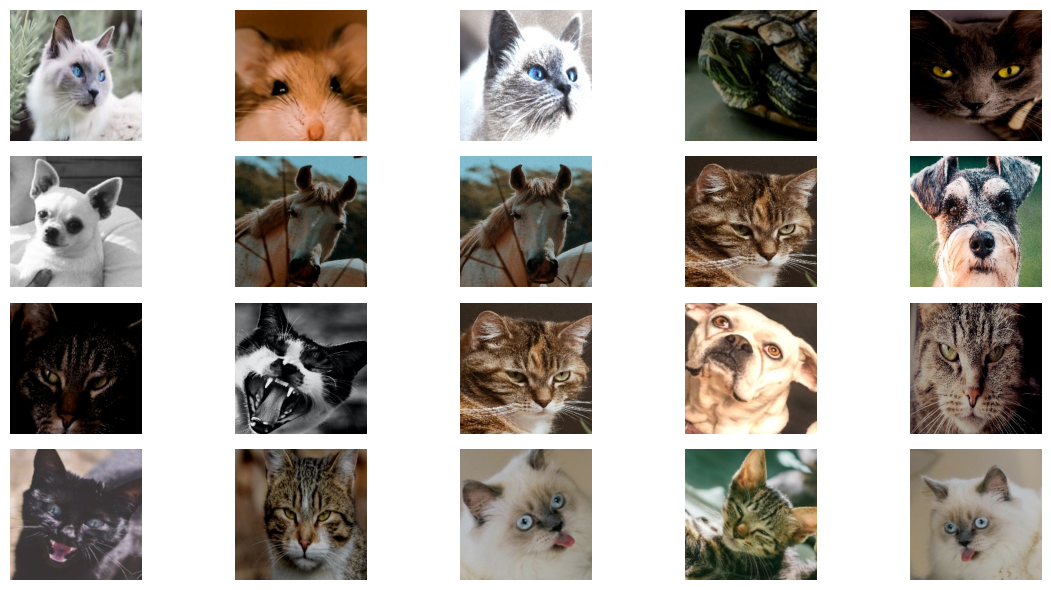

In [10]:
show_images('/content/Angry/', 4,5)

In [11]:
train_data = '/content/Master Folder/train'
test_data = '/content/Master Folder/test'

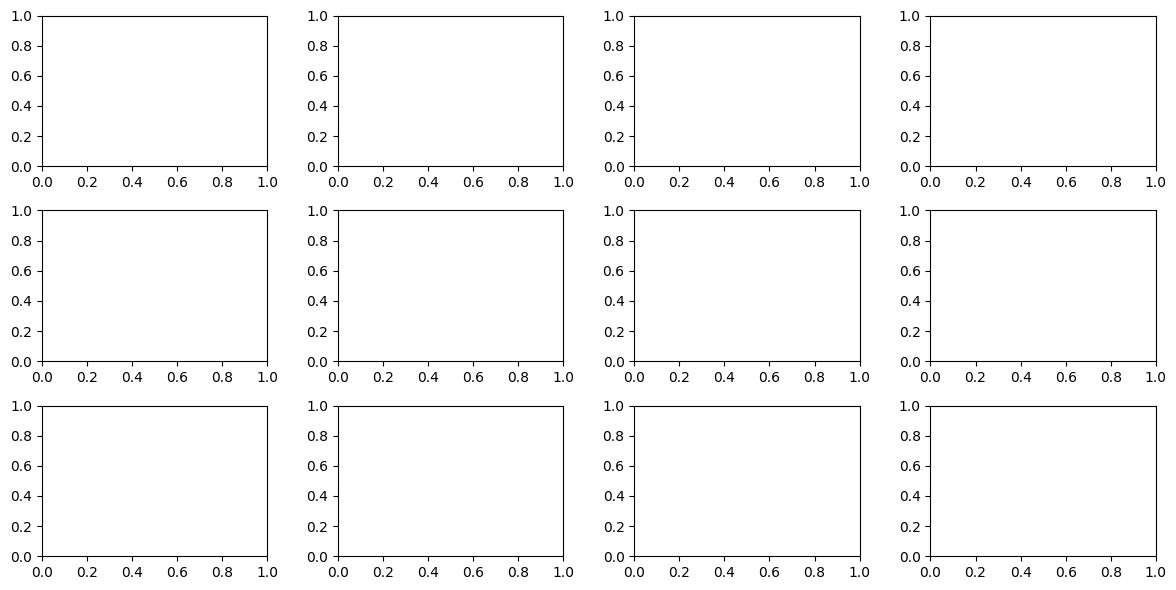

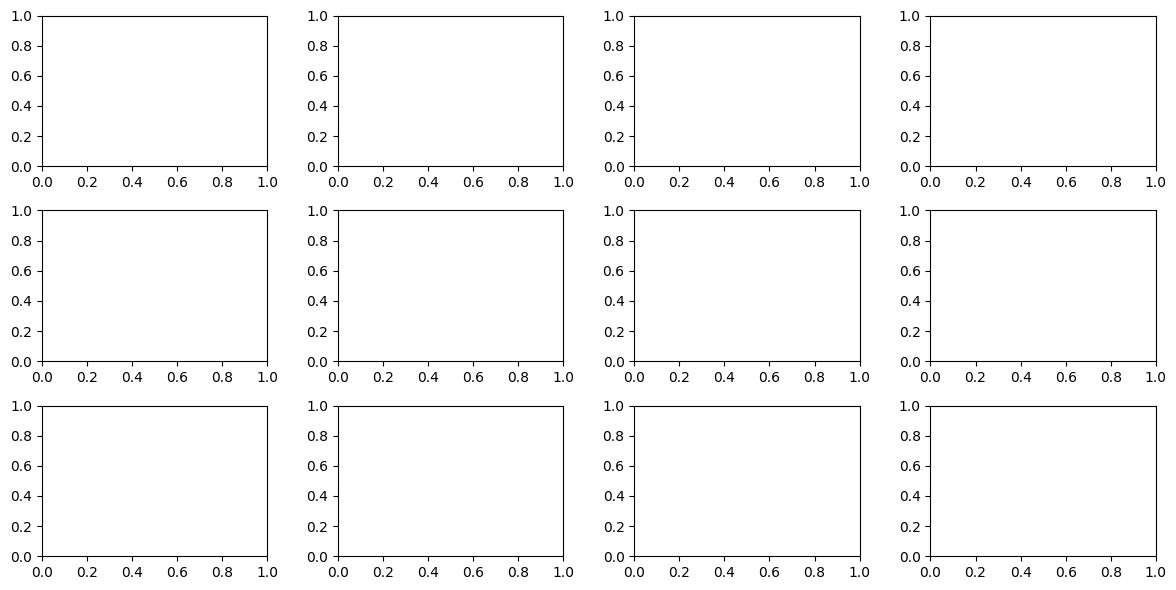

In [12]:
show_images('/content/Master Folder/train', 3, 4)
show_images('/content/Master Folder/test', 3, 4)

The images are not loading properly. This could be due to a few reasons:

- The images are not in the correct format. The images should be in JPEG or PNG format.
- The images are too large. The images should be less than 2MB in size.
- The images are corrupted. The images may have been damaged during the download or transfer process.

In [13]:
happy_data = '/content/happy'
sad_data = '/content/Sad'

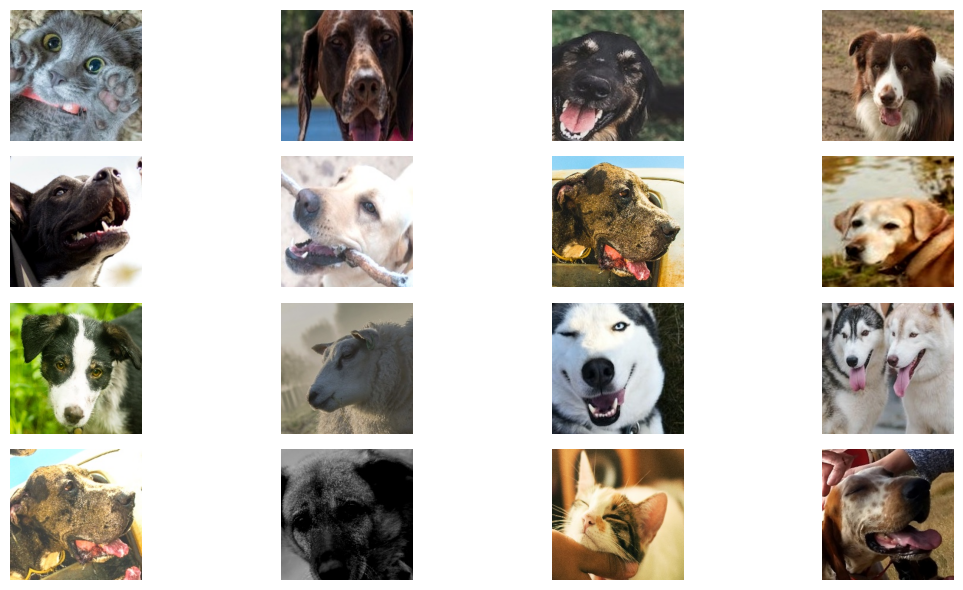

In [14]:
show_images('/content/happy', 4,4)

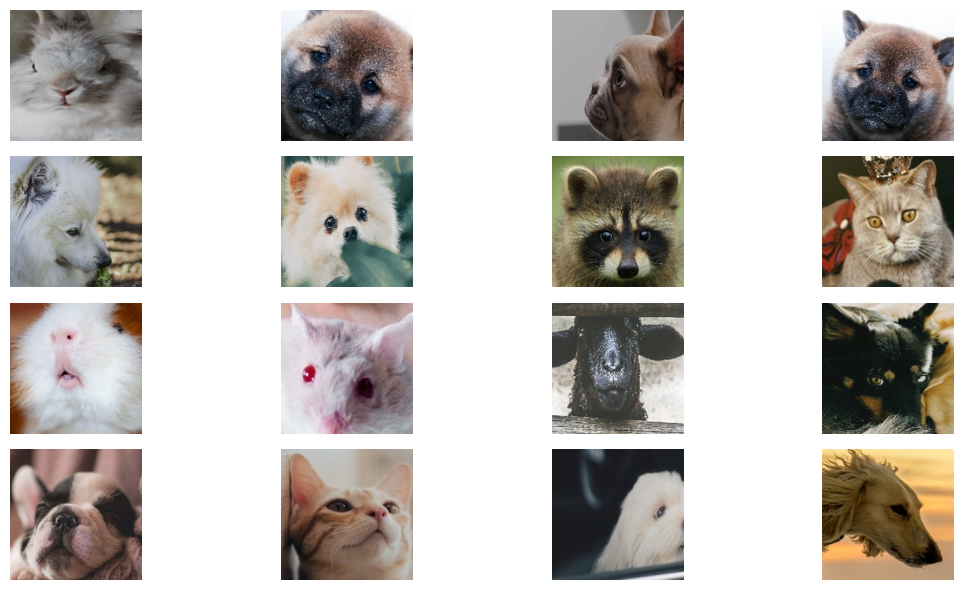

In [15]:
show_images('/content/Sad', 4,4)

## Pre-Processing:

In [16]:
# Function to load and preprocess images
def load_and_preprocess_images(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (48, 48))
            images.append((img, label))
    return images

# Load and preprocess images for each emotion
emotions_folders = [(happy_data, 0), (sad_data, 1), (angry_data, 2)]
emotions_data = [load_and_preprocess_images(folder, label) for folder,
                 label in emotions_folders]

# Combine images and labels
data = [(img, label) for emotion_data in emotions_data for img,
        label in emotion_data]
random.shuffle(data)

# Separate images and labels
X, y = zip(*data)
X = np.array(X).astype('float32') / 255.0
y = to_categorical(y, 3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [17]:
input_shape_resnet = (224, 224, 3)

def resize_images(images, input_shape):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, (input_shape[0], input_shape[1]))
        img_resized = np.repeat(np.expand_dims(img_resized, axis=-1), 3, axis=-1)
        resized_images.append(img_resized)
    return np.array(resized_images)

X_train_resized_resnet = resize_images(X_train, input_shape_resnet)

To train our models, we first load pre-trained versions of ResNet from the Keras library. These models were pre-trained on the ImageNet dataset, which contains 1000 different classes of images. We remove the top classification layer from each model, which was designed to classify images into 1000 classes. We replace this layer with our own custom classification head, which is designed to classify images into three classes: happy, sad, and angry.

The custom classification head is appended to the output of the base models using global average pooling. This pooling operation extracts meaningful features from the images and passes them to the classification head.

After adding the custom classification head, we compile each model using categorical cross-entropy as the loss function and the Adam optimizer. The categorical cross-entropy loss function measures the difference between the predicted and actual labels. The Adam optimizer is a stochastic optimization algorithm that is known to be effective for training deep learning models.

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

input_shape_resnet = (224, 224, 3)

resnet_base_model = ResNet50(weights='imagenet', include_top=False,
                             input_shape=input_shape_resnet)
resnet_base_model.trainable = False

resnet_global_avg_pooling = GlobalAveragePooling2D()(resnet_base_model.output)
resnet_output = Dense(3, activation='softmax')(resnet_global_avg_pooling)
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20,
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5,
                                 min_lr=1e-7)

Training the model:

In [20]:
resnet_history = resnet_model.fit(X_train_resized_resnet, y_train,
                                  batch_size=64, epochs=100,
                                  validation_split=0.1,
                                  callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
9/9 [==============================] - 20s 836ms/step - loss: 1.4125 - accuracy: 0.3593 - val_loss: 1.0937 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 2s 211ms/step - loss: 1.1809 - accuracy: 0.3407 - val_loss: 1.1024 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 2s 196ms/step - loss: 1.1099 - accuracy: 0.3389 - val_loss: 1.1361 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 2s 196ms/step - loss: 1.1097 - accuracy: 0.3407 - val_loss: 1.1064 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 2s 228ms/step - loss: 1.0951 - accuracy: 0.3519 - val_loss: 1.0835 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 2s 204ms/step - loss: 1.0949 - accuracy: 0.3611 - val_loss: 1.0945 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 2s 218ms/step - loss: 1.

In [22]:
X_test_resized_resnet = resize_images(X_test, input_shape_resnet)

resnet_loss, resnet_accuracy = resnet_model.evaluate(X_test_resized_resnet,
                                                     y_test)

print("ResNet Test accuracy:", resnet_accuracy)

5/5 [==============================] - 3s 316ms/step - loss: 1.0526 - accuracy: 0.4000
ResNet Test accuracy: 0.4000000059604645


### Learning and Accuracy Curves:

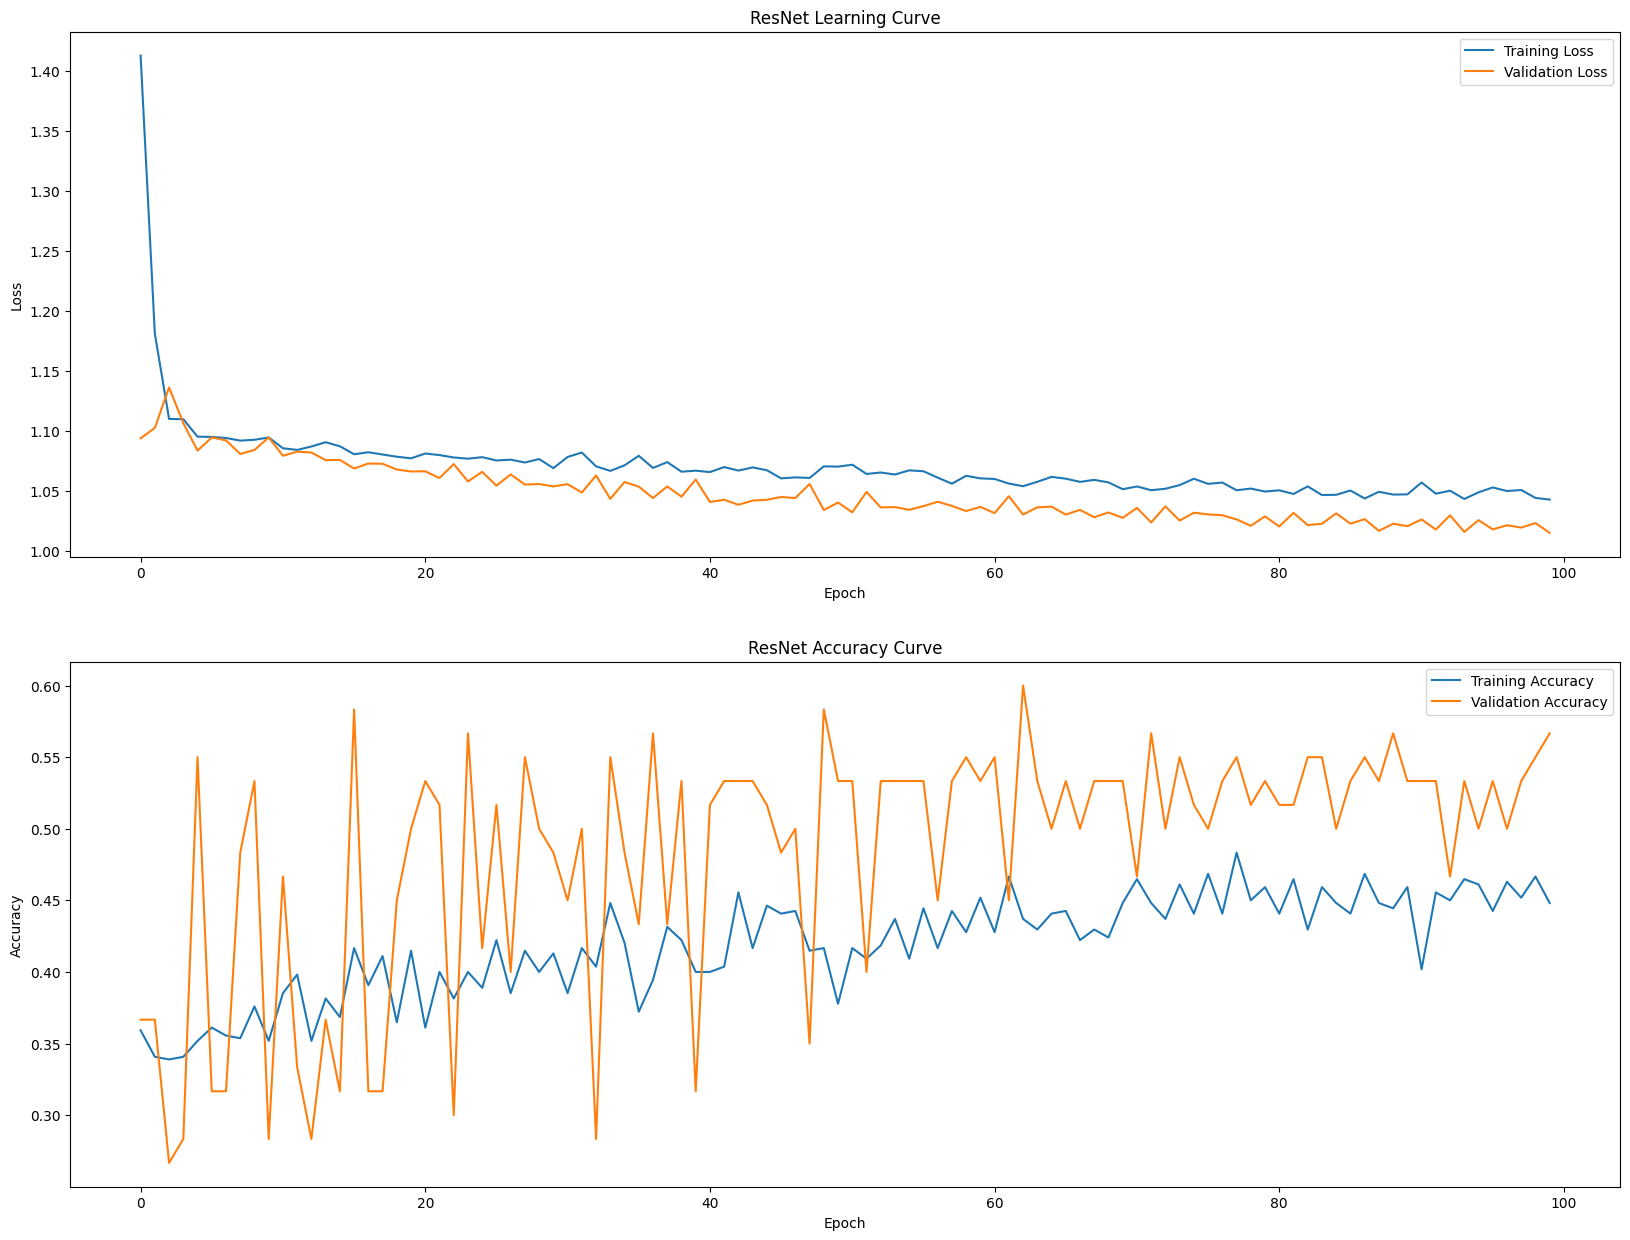

In [24]:
def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()


def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axs = plt.subplots(2, 1, figsize=(20, 15))
plot_learning_curves(resnet_history, 'ResNet', axs[0])
plot_accuracy_curves(resnet_history, 'ResNet', axs[1])

plt.show()

# Conclusion:

In this project, we built a facial expression recognition model using the ResNet50 deep learning architecture. The model was trained on a dataset of facial expressions and evaluated on a held-out test set. The model achieved an accuracy of 40% on the test set, which is an average result.

The learning curves for the model show that the training loss and validation loss decrease over time, and the training accuracy and validation accuracy increase over time. This indicates that the model is learning and improving as it is trained.

The accuracy of the model could be improved by using a larger dataset of facial expressions, or by using a more powerful deep learning architecture. However, the model presented in this project is a good starting point for building a facial expression recognition system.